### A Song of Vice and Higher: Characterizing Presidential Nominees through Game of Thrones

#### Table of Contents

**<a href=#get_data>Get Data</a>**

**<a href=#attribution>Comment Attribution</a>**

**<a href=#person_sentiment>Sentiment by Person</a>**

**<a href=#clusters>Cluster Analysis</a>**

**<a href=#embeddings>Word Embeddings</a>**

### Import Necessary Libraries

In [267]:
import os             # file system stuff
import json           # digest json
import pandas as pd   # Dataframes
import numpy as np    # arrays and matrix ops
import string         # string manipulation

import psycopg2 as psql # PostgreSQL
from itertools import chain # Chain

# Plotting
import matplotlib.pyplot as plt
import plotly_express as px

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import gensim         # Word embeddings

# Custom Libs
import helper     # Custom helper functions
from helper import attribute_comment 
from helper import person_dict



### Connect to the database <a name="get_data"/>

In [17]:
# Define path to secret

# secret_path_aws = os.path.join(os.environ['HOME'], 'mia', '.secret', 
#                            'aws_ps_flatiron.json')
secret_path_aws = os.path.join(os.environ['HOME'], '.secret', 
                           'aws_ps_flatiron.json')
secret_path_aws

'/Users/werlindo/.secret/aws_ps_flatiron.json'

In [18]:
aws_keys = helper.get_keys(secret_path_aws)
user = aws_keys['user']
ps = aws_keys['password']
host = aws_keys['host']
db = aws_keys['db_name']

aws_ps_engine = ('postgresql://' + user + ':' + ps + '@' + host + '/' + db)

# Setup PSQL connection
conn = psql.connect(
    database=db,
    user=user,
    password=ps,
    host=host,
    port='5432'
)

In [19]:
get_database = """
    SELECT * FROM comms_sntmnt_190612;
"""
# Instantiate cursor
cur = conn.cursor()
cur.execute(get_database)
comments = pd.DataFrame(cur.fetchall())
comments.columns = [col.name for col in cur.description]
comments.drop('index', axis=1, inplace=True) #superfluous column
comments.drop(['compound', 'neu'], axis=1, inplace=True) 
#compound and neutral are correlated with other sentiment columns

In [20]:
comments.head()

,comment,domain,neg,pos
0,yeah. i think people imprint modern sensibilit...,got,0.017,0.087
1,"yeah, i think so. funny how that works.",got,0.000,0.519
2,yeah i think so too. even though by the end it...,got,0.120,0.231
3,yeah i think that definitely had something to ...,got,0.095,0.286
4,yeah i think that last watch documentary reall...,got,0.098,0.258


## Attribute Comment to Person <a name='attribution' />

In order to attribute people to `comment`s, we can perform count vectorization. We will need to create a vocabulary.

In [219]:
# Vocabulary will be list of all the search terms we used 
# to pull reddit submissions
vocab = list(chain(*helper.person_dict.values()))

vocab[:10]

Next, set up vectorizer, and then vectorize on this `vocab`

In [241]:
vectorizer = CountVectorizer(vocabulary=vocab)

vectorized_words = vectorizer.transform(comments['comment'])

In [242]:
vectorized_words.shape

(305899, 89)

This gets us an $axn$ matrix, where:
- $a$ is the number of _comments_
- $n$ is the number of _vocab words (search terms)_.

Let's take a look at the vectorized words. Here's one row.

In [233]:
vectorized_words.todense()[5, :]

matrix([[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

The columns show the count of vocab word in the comment (row).

In [234]:
# Check
vectorizer.vocabulary[:10]

['bran',
 'brandon stark',
 'jon',
 'jon snow',
 'khaleesi',
 'dany',
 'daenerys',
 'danyris',
 'davos',
 'doran']

Now we want to set up a $nxm$ matrix, where:
- $n$ will be number of search terms (e.g. 'dany', daenerys' for **daenerys**) 
- $m$ is the actual number of persons (e.g. **daenerys** herself). 

Let's start with a matrix of `0`s.

In [235]:
person_mat = np.zeros((len(person_dict), len(vocab))).T

person_mat.shape

(89, 66)

Now, let's assign column IDs in the matrix for each _person_.

In [236]:
person_ids = {}

for i, name in enumerate(person_dict.keys()):
    person_ids[name] = i
    
person_ids               

{'bran': 0,
 'jon': 1,
 'dany': 2,
 'davos': 3,
 'doran': 4,
 'cersei': 5,
 'tyrion': 6,
 'sansa': 7,
 'arya': 8,
 'stannis': 9,
 'varys': 10,
 'jamie': 11,
 'brienne': 12,
 'samwell': 13,
 'jorah': 14,
 'theon': 15,
 'hound': 16,
 'littlefinger': 17,
 'joffrey': 18,
 'mountain': 19,
 'robb': 20,
 'dragons': 21,
 'melisandre': 22,
 'bronn': 23,
 'gilly': 24,
 'ramsey': 25,
 'missandei': 26,
 'gendry': 27,
 'grey worm': 28,
 'ned': 29,
 'catelyn': 30,
 'torumund': 31,
 'robert': 32,
 'tommen': 33,
 'viserys': 34,
 'margaery': 35,
 'oberon': 36,
 'night_king': 37,
 'lyanna': 38,
 'jaqen': 39,
 'hodor': 40,
 'ygritte': 41,
 'mance': 42,
 'harris': 43,
 'biden': 44,
 'buttigieg': 45,
 'gillibrand': 46,
 'hickenlooper': 47,
 'klobuchar': 48,
 'warren': 49,
 'booker': 50,
 'inslee': 51,
 'castro': 52,
 'gabbard': 53,
 'sanders': 54,
 'de blasio': 55,
 'bullock': 56,
 'gravel': 57,
 'messam': 58,
 "o'rourke": 59,
 'bennet': 60,
 'delaney': 61,
 'moulton': 62,
 'swalwell': 63,
 'williamson': 6

...and assign row ids for each _search term_.

In [237]:
vocab_ids = {}

for i, word in enumerate(vocab):
    vocab_ids[word] = i
    
vocab_ids                

{'bran': 0,
 'brandon stark': 1,
 'jon': 2,
 'jon snow': 3,
 'khaleesi': 4,
 'dany': 5,
 'daenerys': 6,
 'danyris': 7,
 'davos': 8,
 'doran': 9,
 'cersei': 10,
 'tyrion': 11,
 'sansa': 12,
 'arya': 13,
 'stannis': 14,
 'varys': 15,
 'jamie': 16,
 'brienne': 17,
 'samwell': 18,
 'jorah': 19,
 'theon': 20,
 'hound': 21,
 'sandor': 22,
 'littlefinger': 23,
 'baelish': 24,
 'joffrey': 25,
 'mountain': 26,
 'gregor': 27,
 'robb': 28,
 'drogo': 29,
 'melisandre': 30,
 'bronn': 31,
 'gilly': 32,
 'ramsey': 33,
 'ramsay': 34,
 'missandei': 35,
 'gendry': 36,
 'grey worm': 37,
 'ned': 38,
 'eddard': 39,
 'catelyn': 40,
 'torumund': 41,
 'robert': 42,
 'tommen': 43,
 'viserys': 44,
 'margaery': 45,
 'oberon': 46,
 'night king': 47,
 'lyanna mormont': 48,
 'jaqen': 49,
 'hodor': 50,
 'ygritte': 51,
 'mance': 52,
 'senator harris': 53,
 'k. harris': 54,
 'kamala': 55,
 'kamalaharrisforpresident': 56,
 'biden': 57,
 'joe2020': 58,
 'buttigieg': 59,
 'buttigidg': 60,
 'mayor pete': 61,
 'bootijedge'

Now let's use `person_dict` to fill a 1 where each _search term_ matches it's _person_. 

In [238]:
for name, words in person_dict.items():
    person_id = person_ids[name]
    for word in words:
        vocab_id = vocab_ids[word]
        person_mat[vocab_id, person_id] = 1 

In [239]:
person_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Now we can use matrix multplication to get an $axm$ matrix where:
- $a$: number of _comments_
- $m$: number of _persons_

In [244]:
mentions = vectorized_words @ person_mat 

mentions.shape

(305899, 66)

In [245]:
mentions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Get list of _persons_.

In [36]:
persons = list(person_dict.keys())

Create a dataframe from the matrix, with _persons_ as column headers.

In [246]:
mentions_df = pd.DataFrame(mentions, columns=persons, index=comments.index) 

mentions_df.head()

Create a `comment_length` feature. We think we will use this as some sort of weighting metric, i.e. the longer the comment, the more weight it carries....?

In [42]:
comments['comment_length'] = comments['comment'].str.len()

comments.head()

The `comment`s have served their purpose, so we can drop them. 

In [44]:
com_use = comments.drop(['comment'],axis=1).copy()

com_use.head()

Create a master table that has the sentiment analysis **and** the mentions counts.

In [46]:
snm = com_use.join(mentions_df)

snm.head()

_**Version of table with `comment` column preserved**_


In [111]:
comm_snm = comments.join(mentions_df)

comm_snm.head()

---

### Digression: Saving out dataframe to-date as a tab-delimited file.

**<a href=#bookmark>Click here to skip this section</a>**

#### Write out to tsv

In [113]:
comm_snm.to_csv('comm_snm_190613.tsv', sep='\t')

##### Test reading back in

In [114]:
csnm_test = pd.read_csv('comm_snm_190613.tsv', sep='\t')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [248]:
csnm_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305906 entries, 0 to 305905
Data columns (total 72 columns):
Unnamed: 0        305906 non-null object
comment           305900 non-null object
domain            305899 non-null object
neg               305899 non-null float64
pos               305899 non-null float64
comment_length    305899 non-null float64
bran              305899 non-null float64
jon               305899 non-null float64
dany              305899 non-null float64
davos             305899 non-null float64
doran             305899 non-null float64
cersei            305899 non-null float64
tyrion            305899 non-null float64
sansa             305899 non-null float64
arya              305899 non-null float64
stannis           305899 non-null float64
varys             305899 non-null float64
jamie             305899 non-null float64
brienne           305899 non-null float64
samwell           305899 non-null float64
jorah             305899 non-null float64
theon     

In [249]:
csnm_test.head()

,Unnamed: 0,comment,domain,neg,pos,comment_length,bran,jon,dany,davos,...,bullock,gravel,messam,o'rourke,bennet,delaney,moulton,swalwell,williamson,yang
0,0,yeah. i think people imprint modern sensibilit...,got,0.017,0.087,419.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"yeah, i think so. funny how that works.",got,0.000,0.519,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,yeah i think so too. even though by the end it...,got,0.120,0.231,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,yeah i think that definitely had something to ...,got,0.095,0.286,160.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,yeah i think that last watch documentary reall...,got,0.098,0.258,404.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
csnm_test.shape

(305906, 72)

In [119]:
comm_snm.shape

(305899, 71)

We _gained_ a few rows? and a weird index column. Immaterial for now, for think is easily fixable.

Check file size.

In [125]:
file_path_nm = "comm_snm_190613.tsv"
filesize = os.path.getsize(file_path_nm)/1000000

print("file_path_nm is roughly {:,.0f}MB.".format(filesize))

### End Digression.<a name='bookmark' />

---

## Get aggregate sentiment <a name="person_sentiment" />

We want a table that has `person` on the row, and a column for each `sentiment` metric. We can use matrix multiplication again to achieve that.

In [48]:
mentions.shape

(305899, 66)

In [49]:
# Transpose the mentions matrix
men_t = mentions.T


In [250]:
men_t.shape

(66, 305899)

Isolate just the metrics columns.

In [50]:
# Get the positive sentiment column as an array
features = np.array(snm[['pos','neg','comment_length']])

In [51]:
features.shape

(305899, 3)

Compute target matrix of aggregated sentiment.

In [53]:
snm_agg = men_t @ features 

In [54]:
snm_agg.shape

(66, 3)

This gives us a matrix of rows of **persons** by [ **neg**, **pos**, **comment length** ]. But recall this is matrix multiplication, so it gives us the sumproduct. So we need to take the weighted average.

Create an $mx1$ matrix that represents a column of total comment 'hits' for each `person`.

In [56]:
# Get total comments 'hits' by person
men_t_agg = men_t.sum(axis=1)

In [57]:
men_t_agg.shape

(66,)

In [58]:
num_persons = len(persons)

In [59]:
# We need this as an nx1 array
men_t_agg = np.reshape(men_t_agg,(num_persons,1))

In [60]:
men_t_agg.shape

(66, 1)

Now divide the original matrix by 'hits' to get average 'scores'.

In [61]:
snm_avg = np.divide(snm_agg, men_t_agg)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [62]:
snm_avg[0]

array([9.59878097e-02, 9.64360991e-02, 8.40284048e+02])

This looks right. Now make `persons_df`

In [303]:
persons_df = pd.DataFrame(snm_avg, columns=['neg','pos','comment_length'])

In [304]:
# Add the person's name back in
persons_df['person'] = persons

In [308]:
# Add domain back in
persons_df['domain'] = persons_df['person'].map(domain_dict)

In [310]:
persons_df = persons_df[['person', 'domain', 'neg', 'pos', 'comment_length']]

In [311]:
persons_df.head()

,person,domain,neg,pos,comment_length
0,bran,got,0.095988,0.096436,840.284048
1,jon,got,0.106073,0.123129,795.647152
2,dany,got,0.101256,0.136458,895.267485
3,davos,got,0.123971,0.091164,667.975728
4,doran,got,0.089429,0.125000,557.964286


In [312]:
persons_df.sort_values(by=['comment_length'], axis=0, ascending=False)

,person,domain,neg,pos,comment_length
36,oberon,got,0.088133,0.170600,1733.733333
53,gabbard,dems,0.107543,0.092400,1340.477692
40,hodor,got,0.057733,0.058745,932.747700
20,robb,got,0.098743,0.132463,911.203390
26,missandei,got,0.105493,0.144823,901.324723
2,dany,got,0.101256,0.136458,895.267485
21,dragons,got,0.104152,0.131787,876.966423
5,cersei,got,0.103662,0.141583,870.116590
12,brienne,got,0.115310,0.112470,868.582496
7,sansa,got,0.106759,0.116573,844.236661


That's it! We will deal with NA's as situations come up.

---

## Cluster Analysis <a name='clusters'/>

### Data Setup

In [315]:
# Create a person-indexed df
persons_cluster = persons_df.set_index(['person']).drop(['domain'], axis=1)

In [316]:
persons_cluster.head()

,neg,pos,comment_length
person,,,
bran,0.095988,0.096436,840.284048
jon,0.106073,0.123129,795.647152
dany,0.101256,0.136458,895.267485
davos,0.123971,0.091164,667.975728
doran,0.089429,0.125000,557.964286


In [317]:
persons_cluster.shape

(66, 3)

Drop any nulls.

In [318]:
persons_cluster = persons_cluster.dropna(axis=0)

persons_cluster.shape

(61, 3)

In [319]:
persons_cluster.head()

,neg,pos,comment_length
person,,,
bran,0.095988,0.096436,840.284048
jon,0.106073,0.123129,795.647152
dany,0.101256,0.136458,895.267485
davos,0.123971,0.091164,667.975728
doran,0.089429,0.125000,557.964286


Scale the data.

In [360]:
ss = StandardScaler()

ss.fit(persons_cluster)

scaled_X = ss.transform(persons_cluster)

scaled_df = pd.DataFrame(scaled_X, columns=persons_cluster.columns
                         , index=persons_cluster.index)

scaled_df.head()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype int32, float64 were all converted to float64 by StandardScaler.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning:

Data with input dtype int32, float64 were all converted to float64 by StandardScaler.



,neg,pos,comment_length,cluster
person,,,,
bran,-0.886660,-0.135649,0.710875,-0.786436
jon,-0.182250,0.747524,0.503477,-0.786436
dany,-0.518717,1.188530,0.966346,-0.786436
davos,1.067894,-0.310089,-0.089726,0.136114
doran,-1.344808,0.809428,-0.600875,-0.786436


### Find optimal K

**Elbow Method**

In [361]:
# Elbow Method
cluster_variation = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    cluster_variation.append(kmeans.inertia_)

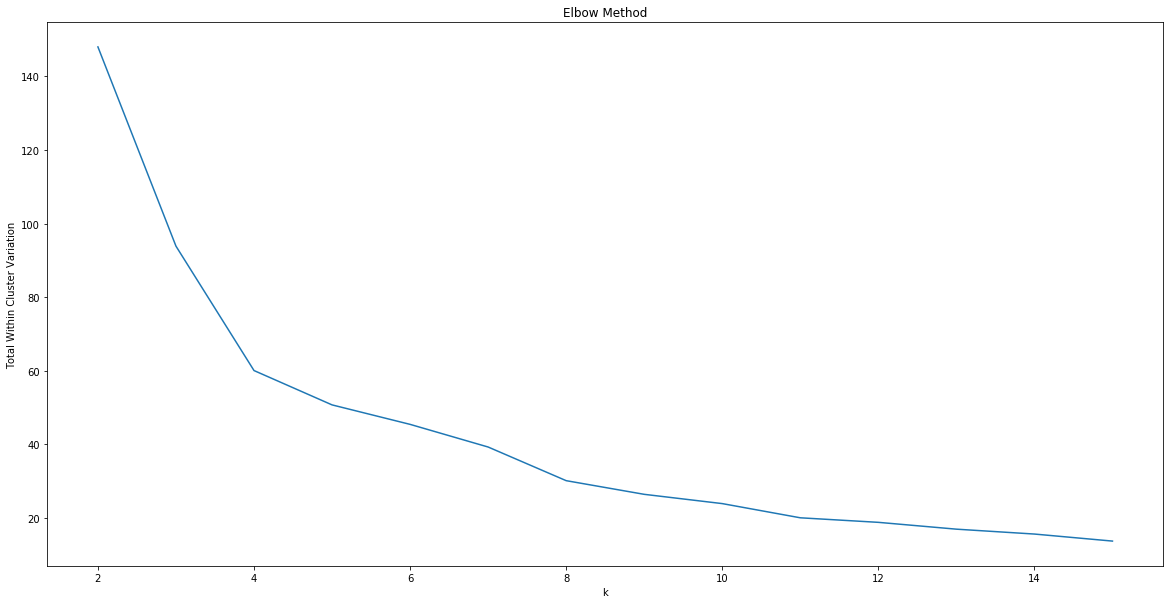

In [362]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Total Within Cluster Variation')
plt.title('Elbow Method')
plt.plot(range(2,16), cluster_variation)


Interesting. Right now we would say k in {4,8}

### Silhouette Method

In [363]:
silhouette_score = []

for k in range(2,16):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(scaled_df)
    labels = kmeans.labels_
    
    score = metrics.silhouette_score(scaled_df, labels, metric='euclidean')
    silhouette_score.append(score)

In [364]:
#Check 
silhouette_score

[0.43329719651807574,
 0.49709098440328625,
 0.533583754334821,
 0.5336776097605986,
 0.3503016145134357,
 0.37951295397176676,
 0.34082322106034846,
 0.3398637848233809,
 0.31211642849833915,
 0.3311911647946029,
 0.299058677766954,
 0.3094915509351753,
 0.2916109728570037,
 0.3108509759723031]

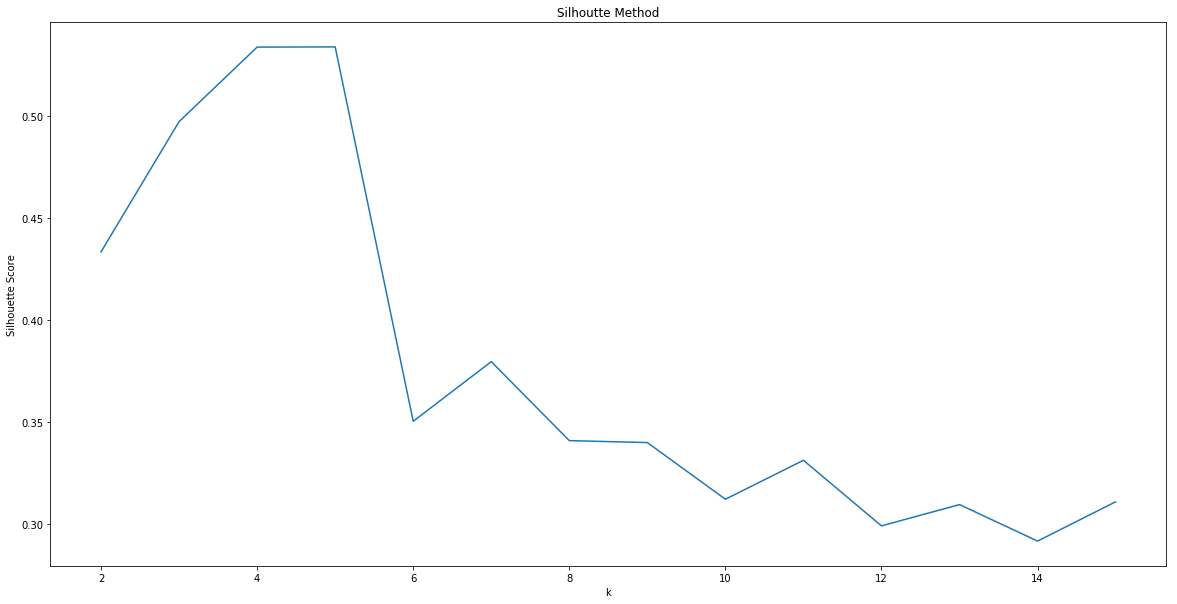

In [365]:
plt.figure(figsize=(20,10))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhoutte Method')
plt.plot(range(2,16), silhouette_score)


For silhouette scores, we are looking for the highest score. This suggests that optimal *k=4*.  Let's remember this for later. For now let's do some PCA.

### Principal Components Analysis

This will help us visualize the clusters.

In [372]:
pca = PCA(n_components=2)

pca_data = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca_data, columns=['PCA_1','PCA_2'])
pca_df.shape


(61, 2)

In [376]:
pca_df = persons_df.dropna()[['person','domain']].join(pca_df)

pca_df.head()

,person,domain,PCA_1,PCA_2
0,bran,got,0.842860,0.463840
1,jon,got,1.186600,-0.198665
2,dany,got,1.788574,0.180724
3,davos,got,-0.570075,-0.677324
4,doran,got,0.968808,0.169932


In [370]:
pca_df.shape

(66, 4)

Let's take a quick digression into plotting our data so far.

In [340]:
px.scatter(data_frame=persons_df.dropna()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='domain'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
           ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

Now let's look by PCA.

In [354]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='domain'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

### K-Means Clustering - k=4

In [385]:
# Model with selected k
k_selected = 4

kmeans = KMeans(n_clusters=k_selected, random_state=42)
kmeans.fit(scaled_df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Add clusters to dataframes.

In [392]:
# Add to pre-PCA DF
persons_cluster['cluster'] = kmeans.labels_.astype(str)

# Add to PCA DF
pca_df['cluster'] = kmeans.labels_.astype(str)

Redo charts, except coded by clusters!

In [390]:
px.scatter(data_frame=persons_cluster.reset_index()
           ,x='neg'
           ,y='pos'
           ,size='comment_length'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Negative vs. Positive Sentiment for Persons | By Cluster'
           ,hover_name='person'
           ,labels={"neg":"Negative Sentiment"
                    ,"pos":"Positive Sentiment"
                    ,"comment_length":"Avg Comment Char Length"
                   }
#            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

In [393]:
px.scatter(data_frame=pca_df
           ,x='PCA_1'
           ,y='PCA_2'
           ,color='cluster'
           ,template='ggplot2'
           ,title='Principal Components Analysis: Comparison'
           ,hover_name='person'
#            ,labels={"neg":"Negative Sentiment"
#                     ,"pos":"Positive Sentiment"
#                     ,"comment_length":"Avg Comment Char Length"
#                    }
            ,color_discrete_map={'got':'orange','dems': 'blue'}
          )

In [92]:
pred_clusters

array([ 0, 10,  9, 11, 13, 14, 10,  0,  7,  4, 10,  4, 14,  4,  7,  7, 12,
       10,  6,  1,  9, 14, 10, 11,  6,  4,  9, 11, 11, 11, 10,  1,  0,  6,
        2,  4,  9,  6,  6, 12, 13,  4,  7,  8,  1, 13,  1, 12, 13,  3, 12,
        5,  5,  8,  7, 11,  1,  8, 13,  8,  4], dtype=int32)

In [93]:
results = persons_cluster.copy()

In [94]:
results

,neg,pos,comment_length
person,,,
bran,0.095988,0.096436,840.284048
jon,0.106073,0.123129,795.647152
dany,0.101256,0.136458,895.267485
davos,0.123971,0.091164,667.975728
doran,0.089429,0.125000,557.964286
cersei,0.103662,0.141583,870.116590
tyrion,0.108100,0.118189,810.833209
sansa,0.106759,0.116573,844.236661
arya,0.099616,0.129261,727.926694


Let's look at clusters in order.

In [395]:
persons_cluster.sort_values(by=['cluster'], axis=0)

,neg,pos,comment_length,cluster
person,,,,
bran,0.095988,0.096436,840.284048,0
gravel,0.108286,0.116970,333.309524,0
mance,0.095934,0.118618,499.368421,0
viserys,0.106836,0.125096,832.946830,0
tommen,0.098590,0.120989,588.302682,0
catelyn,0.114676,0.111942,676.378613,0
ned,0.106553,0.117209,688.115786,0
missandei,0.105493,0.144823,901.324723,0
ramsey,0.108184,0.145236,632.423913,0


----

# Word Embeddings Analysis <a name='embeddings' />

Let's look at analyzing persons by word embeddings. Perhaps they have interesting relationships within the embedding space!

## Create corpus

In [415]:
# Word2Vec requires that our text have the form of a list
# of 'sentences', where each sentence is itself a list of
# words. How can we put our _Jeopardy!_ clues in that shape?

import string
text = []

for comment in comments['comment']:     
    sentence = comment.translate(str.maketrans('', '', 
                                               string.punctuation)).split(' ')
    
    new_sent = []
    for word in sentence:
        new_sent.append(word.lower().strip().replace('\n',''))
    
    text.append(new_sent)

In [416]:
len(text)

305899

In [417]:
# Constructing the model is simply a matter of
# instantiating a Word2Vec object.

model = gensim.models.Word2Vec(text, sg=1)

In [418]:
# To train, call 'train()'!

model.train(text, total_examples=model.corpus_count, epochs=model.epochs)

(46988831, 62302935)

In [419]:
model.corpus_total_words

12460587

### Analyses!

In [420]:
# The '.wv' attribute stores the word vectors
model.wv

**A Game of Throne** and **Democratic Presidential candidates** are ostensibly about determining leadership. So let's see if any persons are most similar to the word `leader`?

In [421]:
leader_terms = model.wv.most_similar('leader', topn=1000)

In [422]:
[term[0] for term in leader_terms]

['ruler',
 'uniter',
 'speaker',
 'leadership',
 'legislator',
 'sullied',
 'protector',
 'commander',
 'leaders',
 'follower',
 'relinquished',
 'dictator',
 'despot',
 'conquerer',
 'fearless',
 'filibusterproof',
 'tolerates',
 'storyteller',
 'dealmaker',
 'swordsman',
 'leaderless',
 'diplomat',
 'invader',
 'policymaker',
 'democratically',
 'monarch',
 'illustrious',
 'benevolent',
 'impotent',
 'liberator',
 'figurehead',
 'conqueror',
 'visionaries',
 'queenits',
 'warrior',
 'jure',
 'docile',
 'neophyte',
 'statesman',
 'position',
 'potus',
 'emperor',
 'idealist',
 'protege',
 'guaido',
 'naturalborn',
 'worshipers',
 'competent',
 'ally',
 'vicepresident',
 'sailor',
 'runningmate',
 'egomaniac',
 'member',
 'madman',
 'abdicated',
 'negotiator',
 'powerfull',
 'unquestioned',
 'cheerleader',
 'presidentand',
 'rhollor',
 'enforcer',
 'recalcitrant',
 'dutiful',
 'migrating',
 'president',
 'candidatethat',
 'parliament',
 'talos',
 'clamor',
 'presidentbut',
 'candidatei

In [218]:
model.wv.most_similar('arya', topn=100)

[('hound', 0.8146053552627563),
 ('ayra', 0.7962175607681274),
 ('sansa', 0.7960515022277832),
 ('sandor', 0.7663037776947021),
 ('jon', 0.7531806230545044),
 ('aryas', 0.7450562715530396),
 ('jamie', 0.7279759645462036),
 ('nk', 0.7274652719497681),
 ('dany', 0.7253828644752502),
 ('jonarya', 0.7220931053161621),
 ('jaime', 0.7125779390335083),
 ('bran', 0.7099167108535767),
 ('danny', 0.7093725800514221),
 ('brienne', 0.7089947462081909),
 ('nymeria', 0.7008751630783081),
 ('aria', 0.6927367448806763),
 ('him', 0.6854960918426514),
 ('cersei', 0.6845852136611938),
 ('theon', 0.6840944290161133),
 ('melisandre', 0.6835671663284302),
 ('jaqen', 0.6809214353561401),
 ('arya\n', 0.6775994300842285),
 ('polliver', 0.6764171719551086),
 ('catspaw', 0.6727741956710815),
 ('waif', 0.6690876483917236),
 ('mel', 0.6673591136932373),
 ('edd', 0.6665385961532593),
 ('nightking', 0.6624770164489746),
 ('cersai', 0.6623581647872925),
 ('davos', 0.6591213941574097),
 ('tnk', 0.6549865007400513),
 (

In [207]:
model.wv.similarity('dany', 'warren')

0.39966395

In [108]:
model.wv.similarity('cersei', 'warren')

0.22205162

In [211]:
model.wv.similarity('deblasio', 'warren')

0.54937315

In [216]:
model.wv.most_similar(['dany'], topn=100)

[('daenerys', 0.9298661947250366),
 ('danny', 0.9198346138000488),
 ('danaerys', 0.8592559099197388),
 ('jon', 0.8356208801269531),
 ('she', 0.8200702667236328),
 ('daenarys', 0.7987155318260193),
 ('her', 0.787189245223999),
 ('dani', 0.7864084243774414),
 ('cersei', 0.7739426493644714),
 ('sansa', 0.7719488739967346),
 ('dany\n\ndany', 0.728047251701355),
 ('danys', 0.7276551723480225),
 ('arya', 0.725382924079895),
 ('tyrion', 0.7233555316925049),
 ('drogon', 0.7168523669242859),
 ('greyworm', 0.7147942781448364),
 ('that', 0.7097795605659485),
 ('danerys', 0.7097747325897217),
 ('he', 0.7089966535568237),
 ('deanerys', 0.7048395872116089),
 ('then', 0.7031346559524536),
 ('varys', 0.7020049095153809),
 ('\n\ndany', 0.7004536390304565),
 ('daeny', 0.6990646123886108),
 ('and', 0.6942039728164673),
 ('cercei', 0.6937738656997681),
 ('everyone', 0.6936644315719604),
 ('him', 0.6910449266433716),
 ('just', 0.6874054670333862),
 ('it', 0.6847954392433167),
 ('her\n\nit', 0.6846177577972

In [212]:
model.wv.most_similar(['deblasio'], topn=100)

[('kamala', 0.695949375629425),
 ('vp\n\ni', 0.6957080364227295),
 ('gravel', 0.6925597190856934),
 ('beefington', 0.6705479621887207),
 ('blasio’s', 0.6548161506652832),
 ('buttigeg', 0.645573079586029),
 ('buttieg', 0.6452294588088989),
 ('position\n\n', 0.6440109014511108),
 ('julián', 0.6400749087333679),
 ('butti', 0.6384601593017578),
 ('cory', 0.6384321451187134),
 ('warrenbooker', 0.6383993029594421),
 ('beto', 0.6373798847198486),
 ('🤦', 0.6366308927536011),
 ('kagan', 0.634278416633606),
 ('orouke', 0.6338492631912231),
 ('antimarijuana', 0.6322070360183716),
 ('klobachar', 0.6321537494659424),
 ('marianne', 0.6298342347145081),
 ('liz', 0.6279640793800354),
 ('swalwell', 0.6271345615386963),
 ('blasio', 0.6265368461608887),
 ('bredesen', 0.625712513923645),
 ('1a', 0.6249392628669739),
 ('bernie\n\nbut', 0.6246531009674072),
 ('duckworth', 0.6244491934776306),
 ('bullock', 0.6237802505493164),
 ('messam', 0.6224069595336914),
 ('moulton', 0.621364951133728),
 ('biden\n\nedit

-----

# Appendix

Prove to myself how matrix division works.

In [ ]:
x = np.matrix([[2,4,6], [4,6,8]])

In [ ]:
x

In [ ]:
y = np.array([2,2]).reshape((2,1))

In [ ]:
y.shape

In [ ]:
g = np.divide(x,y)

In [ ]:
g

In [287]:
abc = 1,000,000

In [288]:
abc

(1, 0, 0)

In [289]:
a b c = 1000 2000 3000

SyntaxError: invalid syntax (<ipython-input-289-fd5f99168ec0>, line 1)

In [291]:
a_b_c

(1, 0, 0)

In [296]:
p_dict = {'bran':'got', 
            'jon':'got', 
            'dany':['khaleesi', 'dany', 'daenerys', 'danyris'], 
           'davos':['davos'],
            'doran':['doran'],
            'cersei':['cersei'],
            'tyrion':['tyrion'],
            'sansa':['sansa'],
            'arya':['arya'],
            'stannis':['stannis'],
            'varys':['varys'],
            'jamie':['jamie'],
            'brienne':['brienne'],
            'samwell':['samwell'],
            'jorah':['jorah'],
            'theon':['theon'],
            'hound':['hound', 'sandor'],
            'littlefinger':['littlefinger', 'baelish'],
            'joffrey':['joffrey'],
            'mountain':['mountain', 'gregor'],
            'robb':['robb'],
            'dragons':['drogo', ],
            'melisandre':['melisandre'],
            'bronn':['bronn'],
            'gilly':['gilly'],
            'ramsey':['ramsey', 'ramsay'],
            'missandei':['missandei'],
            'gendry':['gendry'],
            'grey worm':['grey worm'],
            'ned':['ned', 'eddard'],
            'catelyn':['catelyn'],
            'torumund':['torumund'],
            'robert':['robert'],
            'tommen':['tommen'],
            'viserys':['viserys'],
            'margaery':['margaery'],
            'oberon':['oberon'],'night_king':['night king'],'lyanna':['lyanna mormont'],
            'jaqen':['jaqen'], 'hodor':['hodor'], 'ygritte':['ygritte'], 'mance':['mance'],
               'harris':['senator harris', 'k. harris', 'kamala', 'kamalaharrisforpresident'], 
             'biden':['biden', 'joe2020'],
             'buttigieg':['buttigieg', 'buttigidg', 'mayor pete', 'bootijedge'], 
             'gillibrand':['gillibrand'], 'hickenlooper':['hickenlooper'], 
             'klobuchar':['klobuchar'], 'warren':['warren'], 
             'booker':['booker'], 'inslee':['inslee'], 
             'castro':['castro', 'julián', 'julian'], 'gabbard':['gabbard', 'tulsi'], 
             'sanders':['sanders', 'bernie', 'feelthebern'], 'de blasio':['de blasio'], 
             'bullock':['bullock'], 'gravel':['gravel'], 
             'messam':['messam'], "o'rourke":["o'rourke", "beto"], 
             'bennet':['bennet'], 'delaney':['delaney'], 
             'moulton':['moulton'], 'swalwell':['swalwell'], 
             'williamson':['williamson'], 'yang':['yang']}

In [292]:
this_dict = { 'jon':'snow'
             ,'bran':'stark'
}



In [297]:
import csv

with open('mycsvfile.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, p_dict.keys())
    w.writeheader()
    w.writerow(p_dict)

In [294]:
!pwd

/Users/werlindo/Dropbox/flatiron/fsp/got-demo


In [295]:
!ls

README.md                       dist
__pycache__                     helper.py
a_song_of_vice_and_higher.ipynb mycsvfile.csv
archive                         werlindo.ipynb
comm_snm_190613.tsv


In [301]:
comments.domain.value_counts()

dems    178320
got     127579
Name: domain, dtype: int64

In [302]:
domain_dict = {'bran': 'got'
                ,'jon': 'got'
                ,'dany': 'got'
                ,'davos': 'got'
                ,'doran': 'got'
                ,'cersei': 'got'
                ,'tyrion': 'got'
                ,'sansa': 'got'
                ,'arya': 'got'
                ,'stannis': 'got'
                ,'varys': 'got'
                ,'jamie': 'got'
                ,'brienne': 'got'
                ,'samwell': 'got'
                ,'jorah': 'got'
                ,'theon': 'got'
                ,'hound': 'got'
                ,'littlefinger': 'got'
                ,'joffrey': 'got'
                ,'mountain': 'got'
                ,'robb': 'got'
                ,'dragons': 'got'
                ,'melisandre': 'got'
                ,'bronn': 'got'
                ,'gilly': 'got'
                ,'ramsey': 'got'
                ,'missandei': 'got'
                ,'gendry': 'got'
                ,'grey worm': 'got'
                ,'ned': 'got'
                ,'catelyn': 'got'
                ,'torumund': 'got'
                ,'robert': 'got'
                ,'tommen': 'got'
                ,'viserys': 'got'
                ,'margaery': 'got'
                ,'oberon': 'got'
                ,'night_king': 'got'
                ,'lyanna': 'got'
                ,'jaqen': 'got'
                ,'hodor': 'got'
                ,'ygritte': 'got'
                ,'mance': 'got'
                ,'harris': 'dems'
                ,'biden': 'dems'
                ,'buttigieg': 'dems'
                ,'gillibrand': 'dems'
                ,'hickenlooper': 'dems'
                ,'klobuchar': 'dems'
                ,'warren': 'dems'
                ,'booker': 'dems'
                ,'inslee': 'dems'
                ,'castro': 'dems'
                ,'gabbard': 'dems'
                ,'sanders': 'dems'
                ,'de blasio': 'dems'
                ,'bullock': 'dems'
                ,'gravel': 'dems'
                ,'messam': 'dems'
                ,"o'rourke": 'dems'
                ,'bennet': 'dems'
                ,'delaney': 'dems'
                ,'moulton': 'dems'
                ,'swalwell': 'dems'
                ,'williamson': 'dems'
                ,'yang': 'dems'
              }

In [ ]:
dd